In [1]:
#import
import os
import numpy as np
import scipy as sp
np.random.seed(0)

In [2]:
# load data
workdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/'
A = np.load(os.path.join(workdir, 'schaefer_200_streamlineCount_A.npy'))
A = A[:, :, 0]

In [3]:
print(A.shape)

(200, 200)


## Energy settings

In [4]:
# setup states
n_nodes = A.shape[0]
n_states = int(n_nodes/10)
state_size = int(n_nodes/n_states)

states = np.array([])
for i in np.arange(n_states):
    states = np.append(states, np.ones(state_size) * i)
states = states.astype(int)

In [5]:
print(states)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19]


## Minimum energy

In [6]:
from network_control.utils import matrix_normalization
from network_control.energies import minimum_energy

# settings
T = 1 # time horizon
B = np.eye(n_nodes) # set all nodes as control nodes
A = matrix_normalization(A)

In [7]:
import time
start_time = time.time() # start timer

e = np.zeros((n_states, n_states, n_nodes))
for i in np.arange(n_states):
    x0 = states == i # get ith initial state
    for j in np.arange(n_states):
        xf = states == j # get jth target state
        m_x, m_u, n_err = minimum_energy(A, T, B, x0, xf)
        e[i, j, :] = np.sum(np.square(m_u), axis=0)

end_time = time.time() # stop timer
elapsed_time = end_time - start_time
print('time elapsed in seconds: {:.2f}'.format(elapsed_time)) # print elapsed time

time elapsed in seconds: 30.46


## Minimum energy fast

In [8]:
from network_control.utils import expand_states
x0_mat, xf_mat = expand_states(states)
print(x0_mat.shape, xf_mat.shape)

(200, 400) (200, 400)


In [9]:
from network_control.energies import minimum_energy_fast

start_time = time.time() # start timer

e_fast = minimum_energy_fast(A, T, B, x0_mat, xf_mat)
e_fast = e_fast.transpose().reshape(n_states, n_states, n_nodes)

end_time = time.time() # stop timer
elapsed_time = end_time - start_time
print('time elapsed in seconds: {:.2f}'.format(elapsed_time)) # print elapsed time

time elapsed in seconds: 0.56


In [10]:
print(e.shape)
print(e_fast.shape)

(20, 20, 200)
(20, 20, 200)


### Plots

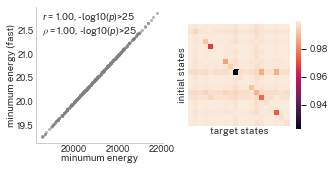

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from network_control.plotting import set_plotting_params, reg_plot
set_plotting_params()

# sum energy over regions
e_sum = np.sum(e, axis=2)
e_fast_sum = np.sum(e_fast, axis=2)

# compute correlations across regional energy for each transition separately
r = np.zeros((n_states, n_states))
for i in np.arange(n_states):
    for j in np.arange(n_states):
        r[i, j] = sp.stats.pearsonr(e[i, j, :], e_fast[i, j, :])[0]

# plot
f, ax = plt.subplots(1, 2, figsize=(5, 2.5))

# correlation between whole-brain energy across state transitions
mask = ~np.eye(n_states, dtype=bool)
indices = np.where(mask)
reg_plot(x=e_sum[indices], y=e_fast_sum[indices], xlabel='minumum energy', ylabel='minumum energy (fast)', ax=ax[0],
         add_spearman=True, kdeplot=False, regplot=False)

# energy correlated across regions for each state transition separately
sns.heatmap(r, square=True, ax=ax[1], cbar_kws={"shrink": 0.80})
ax[1].set_ylabel("initial states", labelpad=-1)
ax[1].set_xlabel("target states", labelpad=-1)
ax[1].set_yticklabels('')
ax[1].set_xticklabels('')
ax[1].tick_params(pad=-2.5)

plt.show()
f.savefig('minimum_energy_fast', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.close()